In [7]:
from matplotlib import pyplot
pyplot.rc("figure", figsize=(30, 30))

In [3]:
# параметры робота
# улавливает расстояния от 0 до 9.5 метров 
# # адекватнее: от 0.5 = это расстояние от центра до края (кстати, когда расстояние РАВНО 0.5, это плохо, потому что мы врезались)
# угол обзора лидара 360 градусов

In [4]:
# входы
# угол м-у осью робота и препятствием (alpha) (градусы)
# расстояние между центром робота и препятствием (s) (м)
# скорость робота (линейная) (v) (м/c)

# в первую очередь судить по alpha
# если s <= 0.5, то мы УЖЕ врезались

In [ ]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import gauss, S, trapezoid, R

# domains
alpha_to_obstacle = Domain("Angle between the robot and an obstacle", 0, 360)
s = Domain("Distance between the robot and an obstacle", 0.5, 9.5)
v = Domain("Current linear speed of the robot (m/s)", 0, 20)

# sets = сделать категории и присвоить им функции принадлежности (NB: моё понимание может быть некорректным)
# alpha
# (для понимания см. рисунок)
# если от 45 до 135, то высокий риск врезаться
# если от 0 до 45 или от 135 до 180, то нужно подумать
# если от 180 до 360, то препятствие сзади, оно нам безразлично
alpha_to_obstacle.average_danger_left_side = S(0, 45)
# начинается не с 45, чтобы пересечение c average_danger_left_side не было нулевым 
# заканчивается не с 135, чтобы пересечение c average_danger_кшпре_side не было нулевым
alpha_to_obstacle.high_danger = trapezoid(35, 60, 120, 145, c_m=1)
alpha_to_obstacle.average_danger_right_side = trapezoid(135, 140, 165, 190, c_m=1)
alpha_to_obstacle.low_danger = R(180, 360)

# s
# v

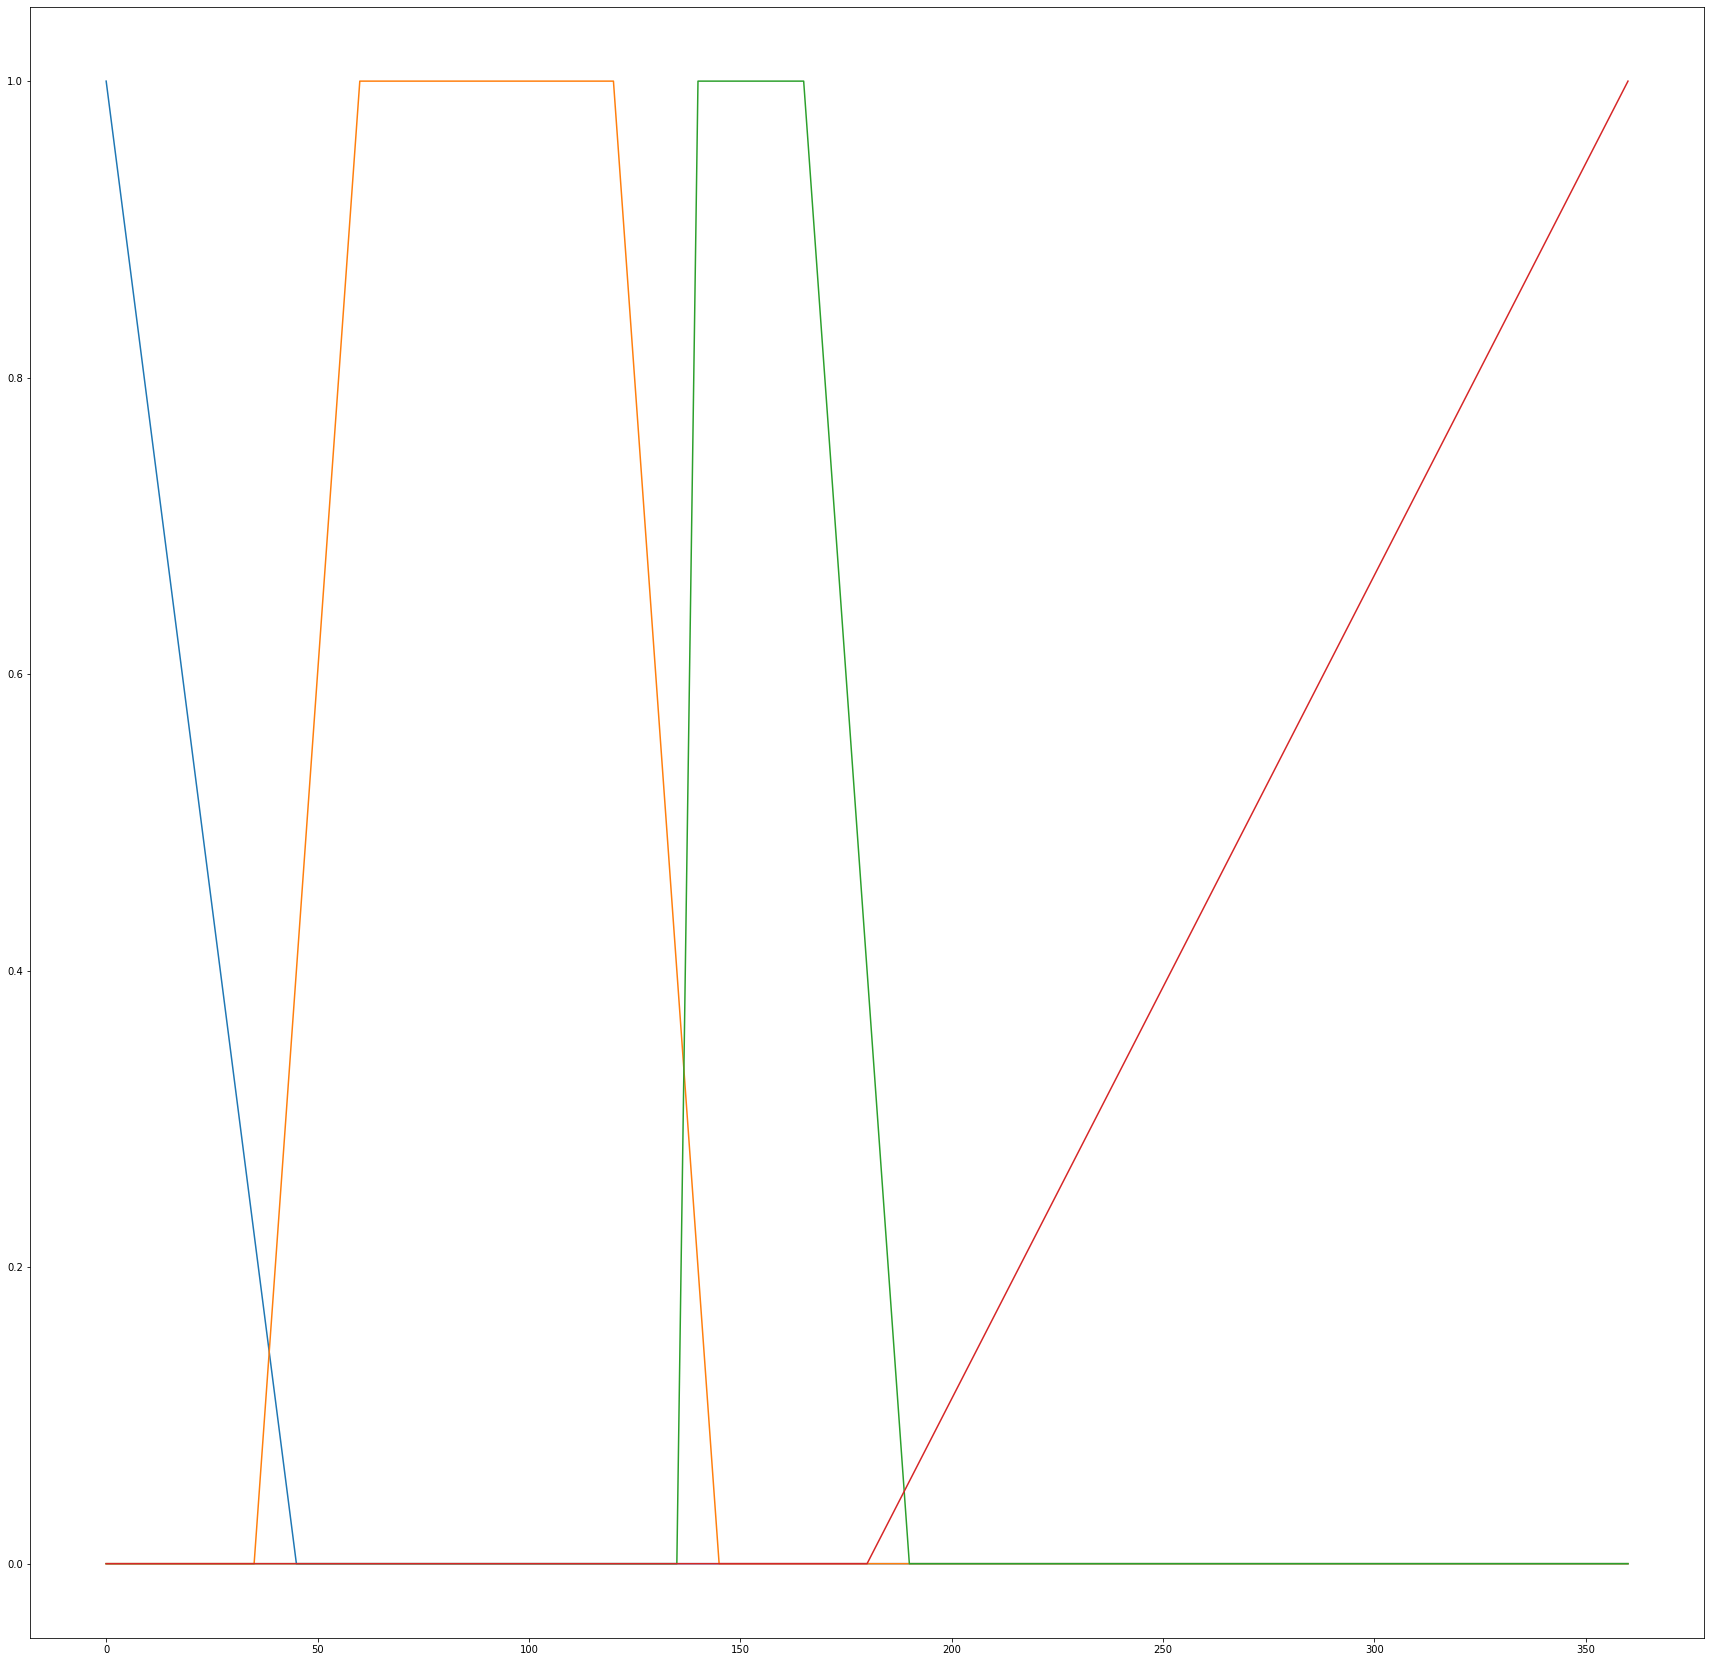

In [8]:
alpha_to_obstacle.average_danger_left_side.plot()
alpha_to_obstacle.high_danger.plot()
alpha_to_obstacle.average_danger_right_side.plot()
alpha_to_obstacle.low_danger.plot()

In [9]:
# выходы
# целевой угол (куда повернётся робот) (gamma) (градусы)
# # насколько я понимаю, целевой угол -- это не "НА СКОЛЬКО градусов надо повернуть колесо относительно текущего положения", а "какое должно быть новое положение колеса с
# # точки зрения угла"
# скорость робота (линейная) (v) (м/c)

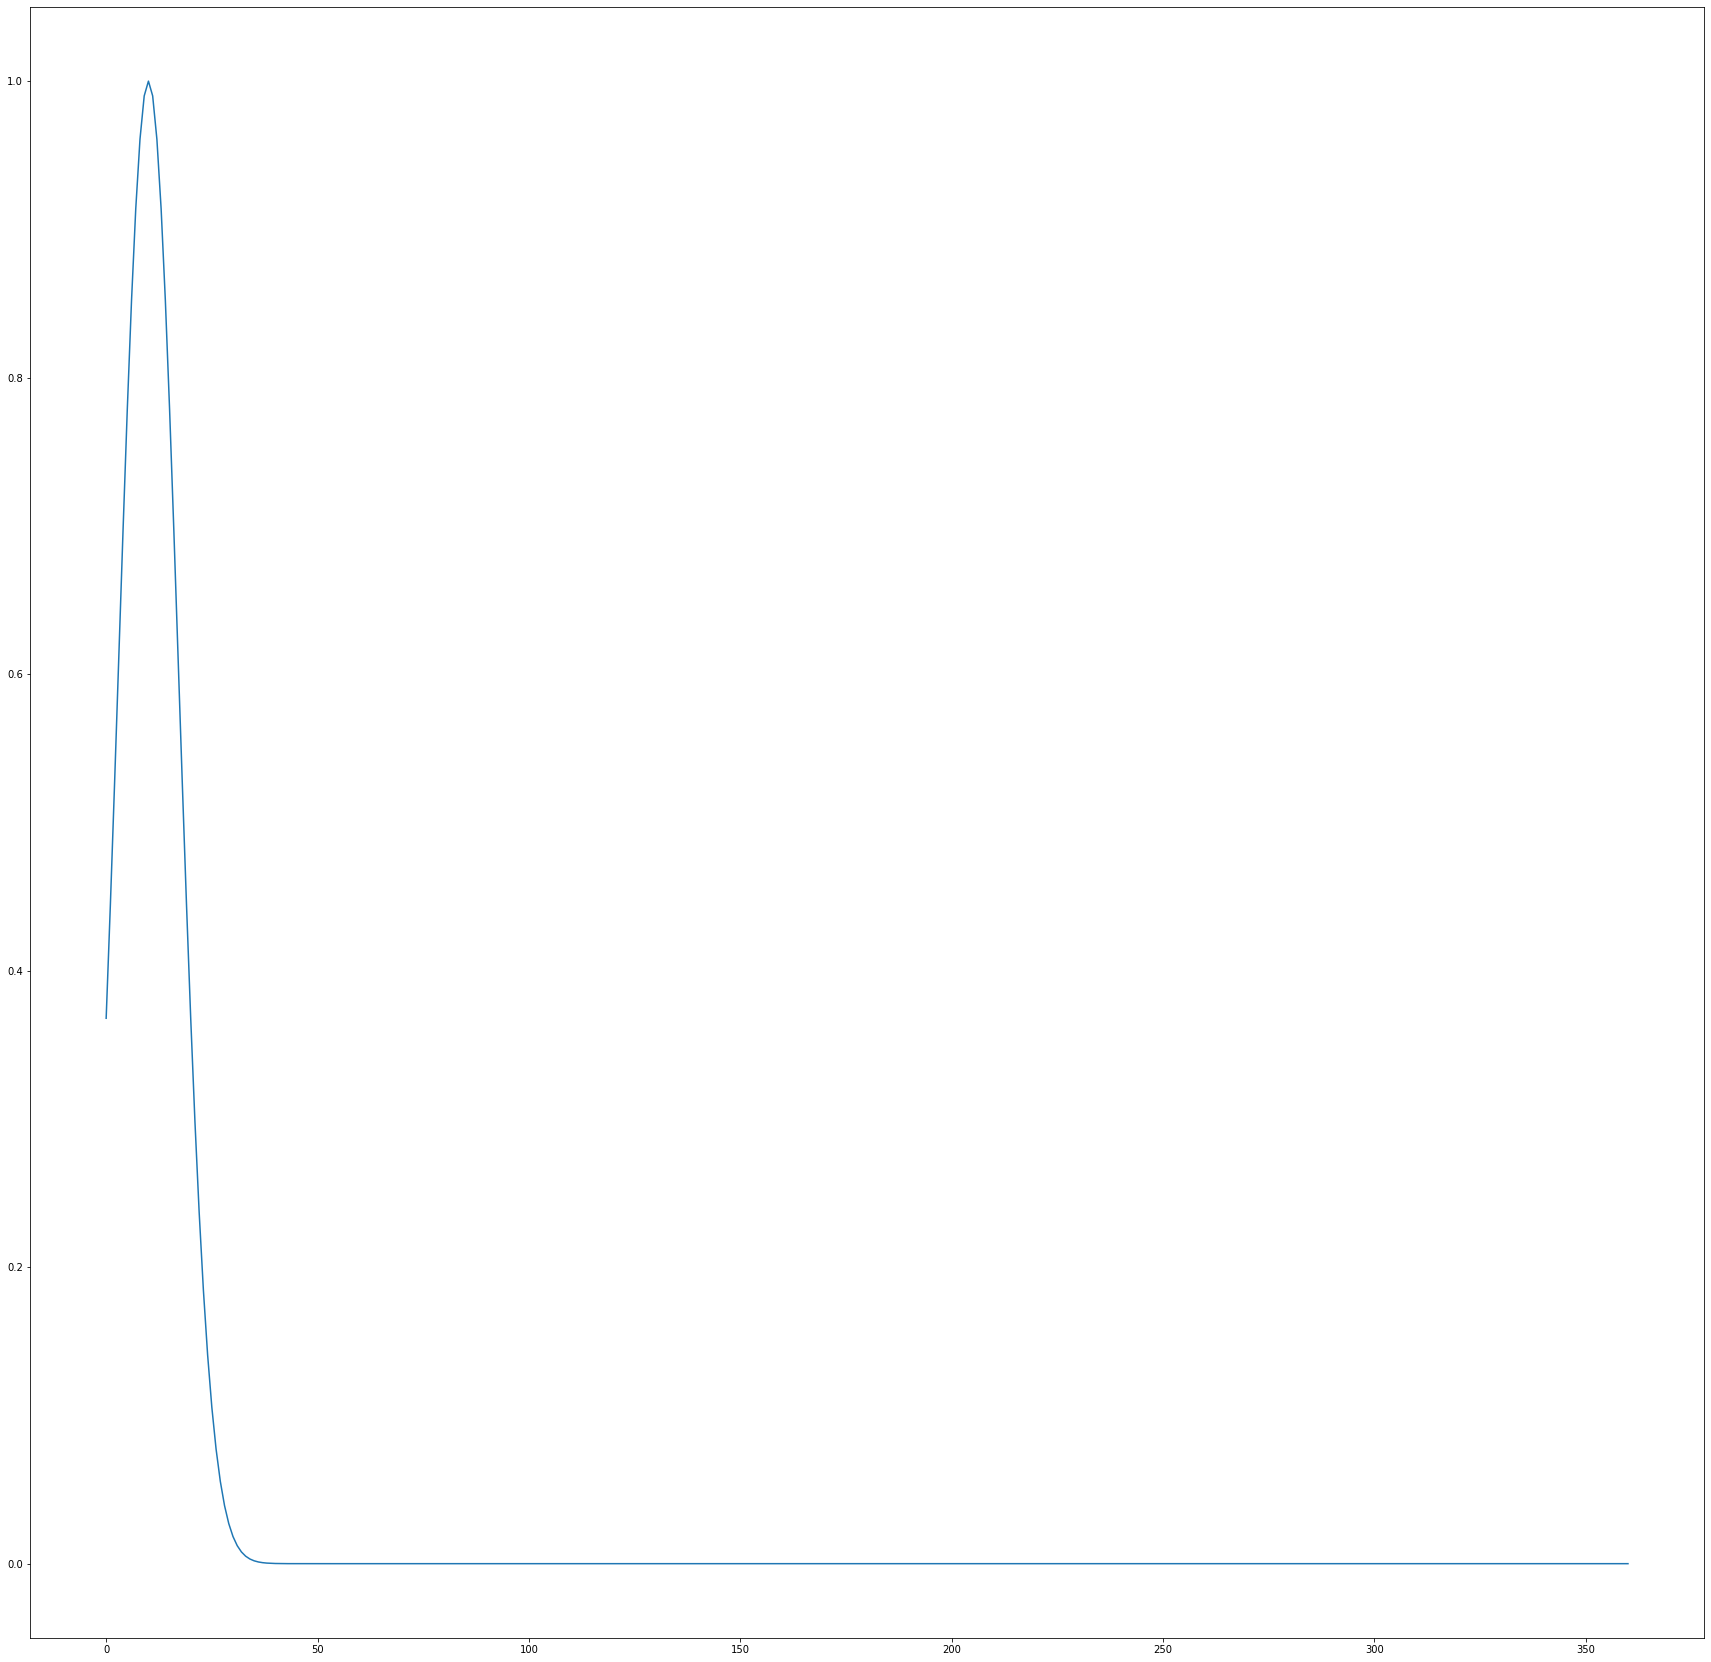

In [10]:
# вспомогательная секция
# про подачу аргументов в gauss
# первое число сделать больше -- пик едет вправо
# второе число сделать меньше -- график шире; сделать больше -- график уже
# c_m = высота пика (какая у графика наибольшая по y точка)
alpha_to_obstacle.dangerously_close = gauss(10, 0.01, c_m=1)
alpha_to_obstacle.dangerously_close.plot()